{/* cspell:ignore LUCJ CCSD ccsd hcore pvdz */}

# Sample-based quantum diagonalization of a chemistry Hamiltonian
*Usage estimate: under one minute on ibm_fez (NOTE: This is an estimate only. Your runtime might vary.)*

## Background

In this tutorial, we show how to post-process noisy quantum samples to find an approximation to the ground state of the nitrogen molecule $\text{N}_2$ at equilibrium bond length, using the [sample-based quantum diagonalization (SQD) algorithm](https://arxiv.org/abs/2405.05068), for samples taken from a 59-qubit quantum circuit (52 system qubits + 7 ancilla qubits). A Qiskit-based implementation is available in the [SQD Qiskit addons](https://github.com/Qiskit/qiskit-addon-sqd), more details can be found in the corresponding [docs](/docs/guides/qiskit-addons-sqd) with a [simple example](/docs/guides/qiskit-addons-sqd-get-started) to get started.
SQD is a technique for finding eigenvalues and eigenvectors of quantum operators, such as a quantum system Hamiltonian, using quantum and distributed classical computing together. Classical distributed computing is used to process samples obtained from a quantum processor, and to project and diagonalize a target Hamiltonian in a subspace spanned by them. This allows SQD to be robust to samples corrupted by quantum noise and deal with large Hamiltonians, such as chemistry Hamiltonians with millions of interaction terms, beyond the reach of any exact diagonalization methods. An SQD-based workflow has the following steps:

1. Choose a circuit ansatz and apply it on a quantum computer to a reference state (in this case, the [Hartree-Fock](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) state).
2. Sample bitstrings from the resulting quantum state.
3. Run the *self-consistent configuration recovery* procedure on the bitstrings to obtain the approximation to the ground state.

SQD is known to work well when the target eigenstate is sparse: the wave function is supported in a set of basis states $\mathcal{S} = \{|x\rangle \}$ whose size does not increase exponentially with the size of the problem.

### Quantum chemistry

The properties of molecules are largely determined by the structure of the electrons within them. As fermionic particles, electrons can be described using a mathematical formalism called second quantization. The idea is that there are a number of *orbitals*, each of which can be either empty or occupied by a fermion. A system of $N$ orbitals is described by a set of fermionic annihilation operators $\{\hat{a}_p\}_{p=1}^N$ that satisfy the fermionic anticommutation relations,

$$
\begin{align*}
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p &= 0, \\
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p &= \delta_{pq}.
\end{align*}
$$

The adjoint $\hat{a}_p^\dagger$ is called a creation operator.

So far, our exposition has not accounted for spin, which is a fundamental property of fermions. When accounting for spin, the orbitals come in pairs called *spatial orbitals*. Each spatial orbital is composed of two *spin orbitals*, one that is labeled "spin-$\alpha$" and one that is labeled "spin-$\beta$". We then write $\hat{a}_{p\sigma}$ for the annihilation operator associated with the spin-orbital with spin $\sigma$ ($\sigma \in \{\alpha, \beta\}$) in spatial orbital $p$. If we take $N$ to be the number of spatial orbitals, then there are a total of $2N$ spin-orbitals. The Hilbert space of this system is spanned by $2^{2N}$ orthonormal basis vectors labeled with two-part bitstrings $\lvert z \rangle = \lvert z_\beta z_\alpha \rangle = \lvert z_{\beta, N} \cdots z_{\beta, 1} z_{\alpha, N} \cdots z_{\alpha, 1} \rangle$.

The Hamiltonian of a molecular system can be written as

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ \frac12
\sum_{ \substack{prqs\\\sigma\tau} }
h_{prqs} \,
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma},
$$

where the $h_{pr}$ and $h_{prqs}$ are complex numbers called molecular integrals that can be calculated from the specification of the molecule using a computer program. In this tutorial, we compute the integrals using the [PySCF](https://pyscf.org/) software package.

For details about how the molecular Hamiltonian is derived, consult a textbook on quantum chemistry (for example, *Modern Quantum Chemistry* by Szabo and Ostlund). For a high-level explanation of how quantum chemistry problems are mapped onto quantum computers, check out the lecture [*Mapping Problems to Qubits*](https://youtube.com/watch?v=TyFU6r8uEsE&t=900) from Qiskit Global Summer School 2024.

### Local unitary cluster Jastrow (LUCJ) ansatz

SQD requires a quantum circuit ansatz to draw samples from. In this tutorial, we'll use the [local unitary cluster Jastrow (LUCJ)](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) ansatz due to its combination of physical motivation and hardware-friendliness.

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken to be the Hartree-Fock state, and the $\hat{K}_\mu$ and $\hat{J}_\mu$ have the form

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;,
$$

where we have defined the number operator

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}.
$$

The operator $e^{\hat{K}_\mu}$ is an orbital rotation, which can be implemented using known algorithms in linear depth and using linear connectivity.
Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$ matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. The constraints are specified by a list of indices indicating which matrix entries in the upper triangle are allowed to be nonzero (since the matrices are symmetric, only the upper triangle needs to be specified). These indices can be interpreted as pairs of orbitals that are allowed to interact.

As an example, consider a square lattice qubit topology. We can place the $\alpha$ and $\beta$ orbitals in parallel lines on the lattice, with connections between these lines forming "rungs" of a ladder shape, like this:

![Qubit mapping diagram for the LUCJ ansatz on a square lattice](/docs/images/tutorials/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd/baad4e53-5bfd-4cb4-8027-2ec26d27ecdd.avif)

With this setup, orbitals with the same spin are connected with a line topology, while orbitals with different spins are connected when they share the same spatial orbital. This yields the following index constraints on the $\mathbf{J}$ matrices:

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

In other words, if the $\mathbf{J}$ matrices are nonzero only at the specified indices in the upper triangle, then the $e^{i \mathcal{J}_k}$ term can be implemented on a square topology without using any swap gates, in constant depth. Of course, imposing such constraints on the ansatz makes it less expressive, so more ansatz repetitions may be required.

The IBM&reg; hardware has a heavy-hex lattice qubit topology, in which case we can adopt a "zig-zag" pattern, depicted below. In this pattern, orbitals with the same spin are mapped to qubits with a line topology (red and blue circles), and a connection between orbitals of different spin is present at every 4th spatial orbital, with the connection being facilitated by an ancilla qubit (purple circles). In this case, the index constraints are


$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, 4, 8, \ldots (p \leq N-1)}
\end{align*}
$$

![Qubit mapping diagram for the LUCJ ansatz on a heavy-hex lattice](/docs/images/tutorials/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd/7e0ee7e1-2d24-417f-ac59-25c58db79aa9.avif)


### Self-consistent configuration recovery

The self-consistent configuration recovery procedure is designed to extract as much signal as possible from noisy quantum samples. Because the molecular Hamiltonian conserves particle number and spin Z, it makes sense to choose a circuit ansatz that also conserves these symmetries. When applied to the Hartree-Fock state, the resulting state has a fixed particle number and spin Z in the noiseless setting. Therefore, the spin-$\alpha$ and spin-$\beta$ halves of any bitstring sampled from this state should have the same [Hamming weight](https://en.wikipedia.org/wiki/Hamming_weight) as in the Hartree-Fock state. Due to the presence of noise in current quantum processors, some measured bitstrings will violate this property. A simple form of postselection would discard these bitstrings, but this is wasteful because those bitstrings might still contain some signal. The self-consistent recovery procedure attempts to recover some of that signal in post-processing. The procedure is iterative and requires as input an estimate of the average occupancies of each orbital in the ground state, which is first computed from the raw samples. The procedure is run in a loop, and each iteration has the following steps:

1. For each bitstring that violates the specified symmetries, flip its bits with a probabilistic procedure designed to bring the bitstring closer to the current estimate of the average orbital occupancies, to obtain a new bitstring.
2. Collect all of the old and new bitstrings that satisfy the symmetries, and subsample subsets of a fixed size, chosen in advance.
3. For each subset of bitstrings, project the Hamiltonian into the subspace spanned by the corresponding basis vectors (see the [previous section](#quantum-chemistry) for a description of these basis vectors), and compute a ground state estimate of the projected Hamiltonian on a classical computer.
4. Update the estimate of the average orbital occupancies with the ground state estimate with the lowest energy.

### SQD workflow diagram

The SQD workflow is depicted in the following diagram:

![Workflow diagram of the SQD algorithm](/docs/images/tutorials/improving-energy-estimation-of-a-fermionic-hamiltonian-with-sqd/fd7e816f-4e2e-4dd7-a7da-f71afb9ca68d.avif)

## Requirements

Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK 1.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
- SQD Qiskit addon 0.11 or later (`pip install qiskit-addon-sqd`)
- ffsim (`pip install ffsim`)

## Setup

In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

## Step 1: Map classical inputs to a quantum problem

In this tutorial, we will find an approximation to the ground state of the molecule at equilibrium in the 6-31G basis set. First, we specify the molecule and its properties.

In [2]:
# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Store reference energy from SCI calculation performed separately
exact_energy = -109.22690201485733

converged SCF energy = -108.929838385609


Before constructing the LUCJ ansatz circuit, we first perform a CCSD calculation in the following code cell. The [$t_1$ and $t_2$ amplitudes](https://en.wikipedia.org/wiki/Coupled_cluster#Cluster_operator) from this calculation will be used to initialize the parameters of the ansatz.

In [3]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.2177884185545  E_corr = -0.2879500329450041


Now, we use [ffsim](https://github.com/qiskit-community/ffsim) to create the ansatz circuit. Since our molecule has a closed-shell Hartree-Fock state, we use the spin-balanced variant of the UCJ ansatz, [UCJOpSpinBalanced](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced). We pass interaction pairs appropriate for a heavy-hex lattice qubit topology (see the [background section on the LUCJ ansatz](#local-unitary-cluster-jastrow-lucj-ansatz)). We set `optimize=True` to compress the t2 amplitudes down to `n_reps` terms (see [Parameter initialization from CCSD in ffsim](https://qiskit-community.github.io/ffsim/explanations/lucj.html) for more details).

In [ ]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]


ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

## Step 2: Optimize problem for quantum hardware execution

Next, we optimize the circuit for a target hardware.

In [13]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=133
)

print(f"Using backend {backend.name}")

Using backend ibm_fez


We recommend the following steps to optimize the ansatz and make it hardware-compatible.

- Select physical qubits (`initial_layout`) from the target hardware that adheres to the "zig-zag" pattern described previously. Laying out qubits in this pattern leads to an efficient hardware-compatible circuit with less gates. Here, we include some code to automate the selection of the "zig-zag" pattern that uses a scoring heuristic to minimize the errors associated with the selected layout.
- Generate a staged pass manager using the [generate_preset_pass_manager](/docs/api/qiskit/qiskit.transpiler.generate_preset_pass_manager) function from qiskit with your choice of `backend` and `initial_layout`.
- Set the `pre_init` stage of your staged pass manager to `ffsim.qiskit.PRE_INIT`. `ffsim.qiskit.PRE_INIT` includes qiskit transpiler passes that decompose gates into orbital rotations and then merges the orbital rotations, resulting in fewer gates in the final circuit.
- Run the pass manager on your circuit.

<details>
<summary>Code for automated selection of "zig-zag" layout</summary>
<CodeCellPlaceholder tag="id-automated-layout-code" />
</details>

In [14]:
from typing import Sequence

import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}


def create_linear_chains(num_orbitals: int) -> PyGraph:
    """In zig-zag layout, there are two linear chains (with connecting qubits between
    the chains). This function creates those two linear chains: a rustworkx PyGraph
    with two disconnected linear chains. Each chain contains `num_orbitals` number
    of nodes, that is, in the final graph there are `2 * num_orbitals` number of nodes.

    Args:
        num_orbitals (int): Number orbitals or nodes in each linear chain. They are
            also known as alpha-alpha interaction qubits.

    Returns:
        A rustworkx.PyGraph with two disconnected linear chains each with `num_orbitals`
            number of nodes.
    """
    G = rustworkx.PyGraph()

    for n in range(num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    return G


def create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """This function creates the complete zigzag graph that 'can be mapped' to an IBM QPU with
    heavy-hex connectivity (the zigzag must be an isomorphic sub-graph to the QPU/backend
    coupling graph for it to be mapped).
    The zigzag pattern includes both linear chains (alpha-alpha interactions) and connecting
    qubits between the linear chains (alpha-beta interactions).

    Args:
        num_orbitals (int): Number of orbitals, that is, number of nodes in each alpha-alpha linear chain.
        backend_coupling_graph (PyGraph): The coupling graph of the backend on which the LUCJ ansatz
            will be mapped and run. This function takes the coupling graph as a undirected
            `rustworkx.PyGraph` where there is only one 'undirected' edge between two nodes,
            that is, qubits. Usually, the coupling graph of a IBM backend is directed (for example, Eagle devices
            such as ibm_brisbane) or may have two edges between two nodes (for example, Heron `ibm_torino`).
            A user needs to be make such graphs undirected and/or remove duplicate edges to make them
            compatible with this function.

    Returns:
        G_new (PyGraph): The graph with IBM backend compliant zigzag pattern.
        num_alpha_beta_qubits (int): Number of connecting qubits between the linear chains
            in the zigzag pattern. While we want as many connecting (alpha-beta) qubits between
            the linear (alpha-alpha) chains, we cannot accommodate all due to qubit and connectivity
            constraints of backends. This is the maximum number of connecting qubits the zigzag pattern
            can have while being backend compliant (that is, isomorphic to backend coupling graph).
    """
    isomorphic = False
    G = create_linear_chains(num_orbitals=num_orbitals)

    num_iters = num_orbitals
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + num_orbitals, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(
            backend_coupling_graph, G_new
        )
        num_iters -= 1

    return G_new, num_alpha_beta_qubits


def lightweight_layout_error_scoring(
    backend: BackendV2,
    virtual_edges: Sequence[Sequence[int]],
    physical_layouts: Sequence[int],
    two_q_gate_name: str,
) -> list[list[list[int], float]]:
    """Lightweight and heuristic function to score isomorphic layouts. There can be many zigzag patterns,
    each with different set of physical qubits, that can be mapped to a backend. Some of them may
    include less noise qubits and couplings than others. This function computes a simple error score
    for each such layout. It sums up 2Q gate error for all couplings in the zigzag pattern (layout) and
    measurement of errors of physical qubits in the layout to compute the error score.

    Note:
        This lightweight scoring can be refined using concepts such as mapomatic.

    Args:
        backend (BackendV2): A backend.
        virtual_edges (Sequence[Sequence[int]]): Edges in the device compliant zigzag pattern where
            nodes are numbered from 0 to (2 * num_orbitals + num_alpha_beta_qubits).
        physical_layouts (Sequence[int]): All physical layouts of the zigzag pattern that are isomorphic
            to each other and to the larger backend coupling map.
        two_q_gate_name (str): The name of the two-qubit gate of the backend. The name is used for fetching
            two-qubit gate error from backend properties.

    Returns:
        scores (list): A list of lists where each sublist contains two items. First item is the layout, and
            second item is a float representing error score of the layout. The layouts in the `scores` are
            sorted in the ascending order of error score.
    """
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])

    return sorted(scores, key=lambda x: x[1])


def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()

    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass

    return backend_coupling_graph


def get_zigzag_physical_layout(
    num_orbitals: int, backend: BackendV2, score_layouts: bool = True
) -> tuple[list[int], int]:
    """The main function that generates the zigzag pattern with physical qubits that can be used
    as an `intial_layout` in a preset passmanager/transpiler.

    Args:
        num_orbitals (int): Number of orbitals.
        backend (BackendV2): A backend.
        score_layouts (bool): Optional. If `True`, it uses the `lightweight_layout_error_scoring`
            function to score the isomorphic layouts and returns the layout with less erroneous qubits.
            If `False`, returns the first isomorphic subgraph.

    Returns:
        A tuple of device compliant layout (list[int]) with zigzag pattern and an int representing
            number of alpha-beta-interactions.
    """
    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)

    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )

    isomorphic_mappings = rustworkx.vf2_mapping(
        backend_coupling_graph, G, subgraph=True
    )
    isomorphic_mappings = list(isomorphic_mappings)

    edges = list(G.edge_list())

    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)

    two_q_gate_name = IBM_TWO_Q_GATES.intersection(
        backend.configuration().basis_gates
    ).pop()

    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )

        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

In [15]:
initial_layout, _ = get_zigzag_physical_layout(num_orbitals, backend=backend)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'rz': 12381, 'sx': 12149, 'cz': 3986, 'x': 559, 'measure': 52, 'barrier': 1})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 7063, 'rz': 6956, 'cz': 1876, 'measure': 52, 'x': 27, 'barrier': 1})


## Step 3: Execute using Qiskit primitives

After optimizing the circuit for hardware execution, we are ready to run it on the target hardware and collect samples for ground state energy estimation. As we only have one circuit, we will use Qiskit Runtime's [Job execution mode](/docs/guides/execution-modes) and execute our circuit.

In [16]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

In [17]:
primitive_result = job.result()
pub_result = primitive_result[0]

## Step 4: Post-process and return result in desired classical format

Now, we estimate the ground state energy of the Hamiltonian using the `diagonalize_fermionic_hamiltonian` function. This function performs the self-consistent configuration recovery procedure to iteratively refine the noisy quantum samples to improve the energy estimate. We pass a callback function so that we can save the intermediate results for later analysis. See the [API documentation](/docs/api/qiskit-addon-sqd/fermion#diagonalize_fermionic_hamiltonian) for explanations of the arguments to `diagonalize_fermionic_hamiltonian`.

In [18]:
from functools import partial

from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -109.00209002409909
		Subspace dimension: 88804
	Subsample 1
		Energy: -109.00209002409909
		Subspace dimension: 88804
	Subsample 2
		Energy: -109.00209002409909
		Subspace dimension: 88804
Iteration 2
	Subsample 0
		Energy: -109.10811744360254
		Subspace dimension: 330625
	Subsample 1
		Energy: -109.1173170913492
		Subspace dimension: 311364
	Subsample 2
		Energy: -109.09775891404614
		Subspace dimension: 316969
Iteration 3
	Subsample 0
		Energy: -109.15752794186847
		Subspace dimension: 488601
	Subsample 1
		Energy: -109.15209904065
		Subspace dimension: 480249
	Subsample 2
		Energy: -109.16136340321759
		Subspace dimension: 467856
Iteration 4
	Subsample 0
		Energy: -109.18124195331923
		Subspace dimension: 633616
	Subsample 1
		Energy: -109.17345094447967
		Subspace dimension: 627264
	Subsample 2
		Energy: -109.17708887805357
		Subspace dimension: 665856
Iteration 5
	Subsample 0
		Energy: -109.18359618095181
		Subspace dimension: 853776
	Subsample 

### Visualize the results

The first plot shows that after a couple of iterations we estimate the ground state energy within ``~69 mH`` (chemical accuracy is typically accepted to be ``1 kcal/mol`` $\approx$ ``1.6 mH``). The energy can be improved by allowing more iterations of configuration recovery or increasing the number of samples per batch.

The second plot shows the average occupancy of each spatial orbital after the final iteration. We can see that both the spin-up and spin-down electrons occupy the first five orbitals with high probability in our solutions.

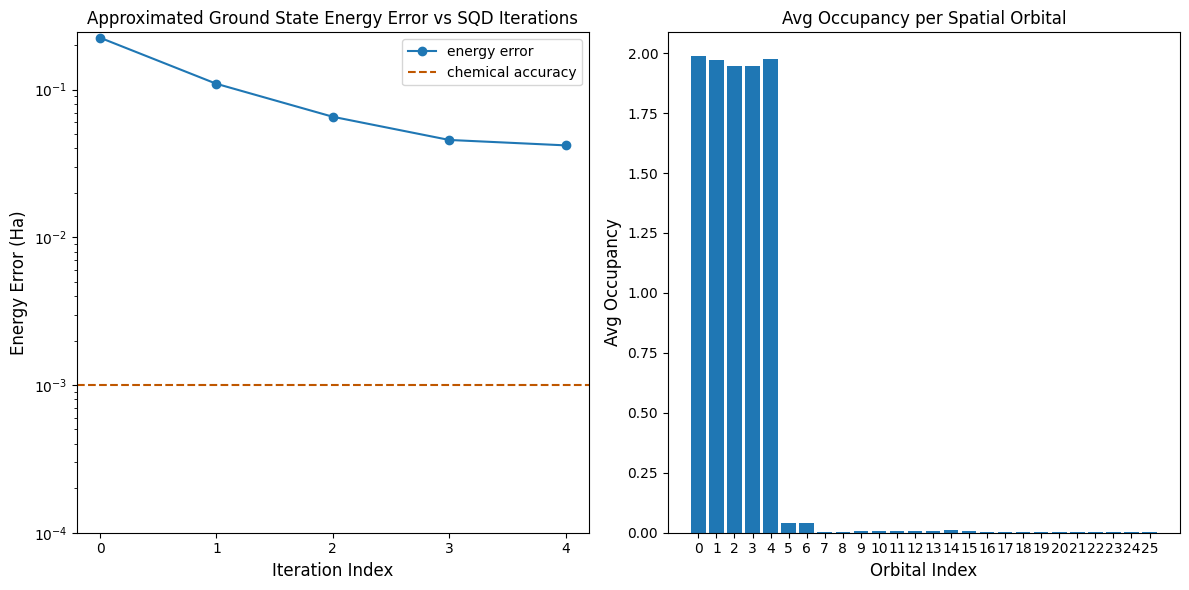

In [19]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Tutorial survey

Please take this short survey to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_8cECHVBBWBjt72S)